Import necessari:

In [36]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.spatial.distance import mahalanobis
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from skimage.feature import hog
from torchvision.io import read_image
from torchvision.transforms import functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA


Set Up

In [9]:
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])


feat_matrix_part1, lbls_part1, flname_part1 = load_features(
    "hog_features_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features(
    "hog_features_part2.npz")

Seconda implementazione

Task 2 : 

In [20]:
# === Funzione: Estrazione HOG ===
def extract_hog_features_from_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))  # dimensione standard

    features, _ = hog(resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

In [21]:
def process_and_save_features(base_folder, subfolders, output_file):
    """Estrae le feature da immagini organizzate in sottocartelle e le salva in un file .npz."""
    all_features, all_filenames, all_labels = [], [], []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_hog_features_from_image(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    print(f"[SALVATO] Features salvate in {output_file}")

In [5]:
# Parametri
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "hog_features_part1.npz")
process_and_save_features("Part2", subfolders, "hog_features_part2.npz")

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in hog_features_part1.npz
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in hog_features_part2.npz


Task 3

Distanza coseno:

In [19]:

# === Funzione: Estrai feature HOG dalla query ===
def extract_hog_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))
    features, _ = hog(resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

# === Funzione: Visualizza immagini simili ===
def show_similar_images(results, base_folder):
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1:
        axes = [axes]
    for ax, (filename, score) in zip(axes, results):
        img_path = None
        # Cerca nei sottocartelle
        for subdir in os.listdir(base_folder):
            candidate_path = os.path.join(base_folder, subdir, filename)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                break
        if img_path:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"{filename}\nSim: {score:.2f}")
            ax.axis('off')
        else:
            ax.set_title(f"Non trovata: {filename}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Funzione principale ===
def find_similar_images_npz(query_path, k, npz_path="hog_features_all.npz", base_folder="Part1"):
    # Carica i dati dal file .npz
    data = np.load(npz_path, allow_pickle=True)
    X = data["features"]
    filenames = data["filenames"]

    # Estrai le feature dalla query
    query_features = extract_hog_features_from_image(img_path)
    if query_features is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    # Calcola la similarità coseno
    similarities = cosine_similarity([query_features], X)[0]

    # Ordina per similarità decrescente
    sorted_indices = np.argsort(similarities)[::-1]
    top_k = sorted_indices[:k]

    results = [(filenames[i], similarities[i]) for i in top_k]

    print(f"[RISULTATI] Le {k} immagini più simili a '{os.path.basename(query_path)}':")
    for fname, score in results:
        print(f"- {fname} (similarità: {score:.4f})")

    show_similar_images(results, base_folder)

# === ESEMPIO DI USO ===
query_image = "Part1/brain_glioma/brain_glioma_0001.jpg"
k = 11
find_similar_images_npz(query_image, k)


NameError: name 'img_path' is not defined

Distanza euclidea:

[RISULTATI] Le 11 immagini più simili a 'brain_glioma_0001.jpg':
- brain_glioma_0001.jpg (distanza: 0.0000)
- brain_glioma_0959.jpg (distanza: 10.9959)
- brain_glioma_0377.jpg (distanza: 11.3684)
- brain_glioma_0480.jpg (distanza: 11.4592)
- brain_glioma_0820.jpg (distanza: 11.5366)
- brain_menin_0454.jpg (distanza: 11.5895)
- brain_glioma_0201.jpg (distanza: 11.6265)
- brain_glioma_0633.jpg (distanza: 11.6492)
- brain_glioma_0102.jpg (distanza: 11.6996)
- brain_glioma_0918.jpg (distanza: 11.7283)
- brain_glioma_0496.jpg (distanza: 11.7303)


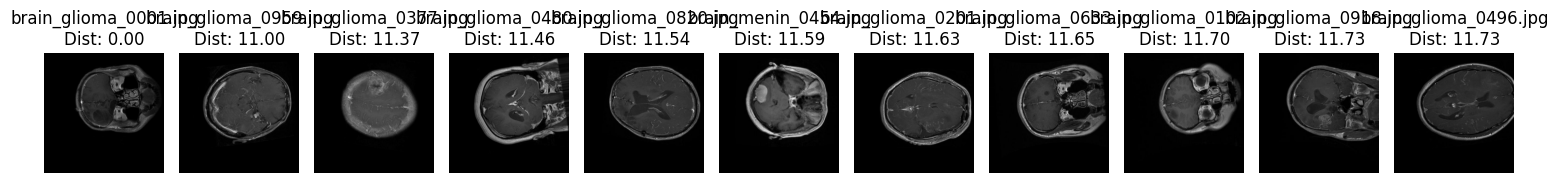

In [13]:


# === Funzione: Visualizza immagini simili ===
def show_similar_images(results, base_folder):
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1:
        axes = [axes]
    for ax, (filename, dist) in zip(axes, results):
        img_path = None
        for subdir in os.listdir(base_folder):
            candidate_path = os.path.join(base_folder, subdir, filename)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                break
        if img_path:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"{filename}\nDist: {dist:.2f}")
            ax.axis('off')
        else:
            ax.set_title(f"Non trovata: {filename}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Funzione principale ===
def find_similar_images_npz(query_path, k, npz_path="hog_features_all.npz", base_folder="Part1"):
    # Carica i dati dal file .npz
    data = np.load(npz_path, allow_pickle=True)
    X = data['features']
    filenames = data['filenames']

    # Estrai feature della query
    query_features = extract_hog_features(query_path)
    if query_features is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    # Calcola distanza euclidea
    distances = euclidean_distances([query_features], X)[0]

    # Ordina per distanza crescente
    sorted_indices = np.argsort(distances)
    top_k = sorted_indices[:k]

    results = [(filenames[i], distances[i]) for i in top_k]

    print(f"[RISULTATI] Le {k} immagini più simili a '{os.path.basename(query_path)}':")
    for fname, dist in results:
        print(f"- {fname} (distanza: {dist:.4f})")

    show_similar_images(results, base_folder)

# === Esempio di utilizzo ===
query_image = "Part1/brain_glioma/brain_glioma_0001.jpg"
k = 11
find_similar_images_npz(query_image, k)


[RISULTATI - cosine] Le 5 immagini più simili a 'brain_menin_0013.jpg':
- brain_menin_0013.jpg (score: 1.0000)
- brain_glioma_0207.jpg (score: 0.7662)
- brain_menin_0582.jpg (score: 0.7495)
- brain_menin_0801.jpg (score: 0.7455)
- brain_tumor_1001.jpg (score: 0.7444)


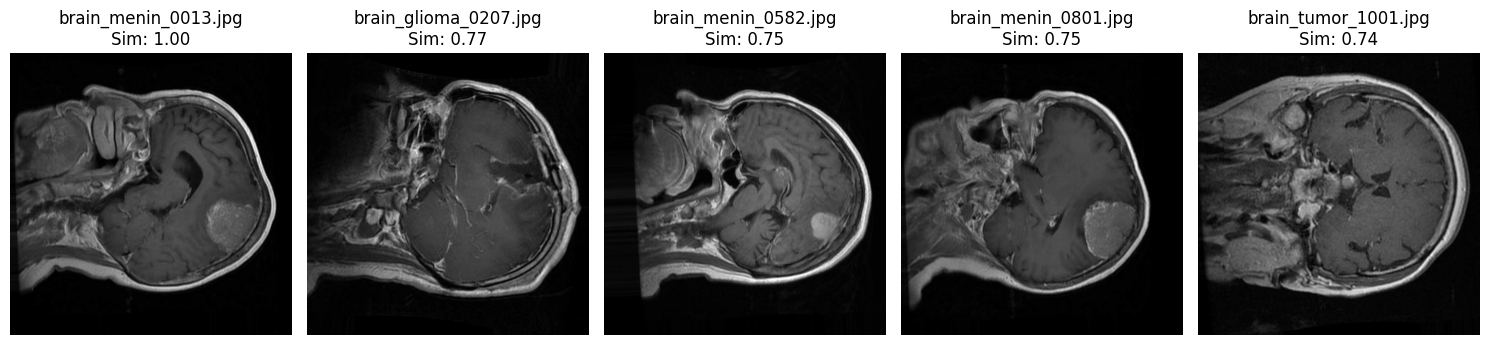

In [22]:
# === Distanza Chi-Squared ===
def chi2_distance(a, b, eps=1e-10):
    return 0.5 * np.sum(((a - b) ** 2) / (a + b + eps))

# === Similarità Correlazione ===
def correlation_similarity(a, B):
    a_mean = a - np.mean(a)
    B_mean = B - np.mean(B, axis=1, keepdims=True)
    num = np.dot(B_mean, a_mean)
    denom = np.linalg.norm(B_mean, axis=1) * np.linalg.norm(a_mean)
    return num / (denom + 1e-10)

# === Visualizza immagini ===
def show_images(results, base_folder):
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1:
        axes = [axes]
    for ax, (filename, score) in zip(axes, results):
        img_path = None
        for subdir in os.listdir(base_folder):
            candidate_path = os.path.join(base_folder, subdir, filename)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                break
        if img_path:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"{filename}\nScore: {score:.2f}")
            ax.axis('off')
        else:
            ax.set_title(f"Non trovata: {filename}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Trova immagini simili ===
def find_similar_images_npz(img_path, k, metric):

    query_features = extract_hog_features_from_image(img_path)
    if query_features is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    # === Calcolo distanza/similarità ===
    if metric == "cosine":
        similarities = cosine_similarity([query_features], feat_matrix_part1)[0]
        sorted_indices = np.argsort(similarities)[::-1]  # similarità -> decrescente
        results = [(flname_part1[i], similarities[i]) for i in sorted_indices[:k]]
    elif metric == "euclidean":
        distances = euclidean_distances([query_features], feat_matrix_part1)[0]
        sorted_indices = np.argsort(distances)  # distanza -> crescente
        results = [(flname_part1[i], distances[i]) for i in sorted_indices[:k]]
    elif metric == "manhattan":
        distances = manhattan_distances([query_features], feat_matrix_part1)[0]
        sorted_indices = np.argsort(distances)
        results = [(flname_part1[i], distances[i]) for i in sorted_indices[:k]]
    elif metric == "chi2":
        distances = np.array([chi2_distance(query_features, feat_matrix_part1) for x in feat_matrix_part1])
        sorted_indices = np.argsort(distances)
        results = [(flname_part1[i], distances[i]) for i in sorted_indices[:k]]
    elif metric == "correlation":
        similarities = correlation_similarity(query_features, feat_matrix_part1)
        sorted_indices = np.argsort(similarities)[::-1]
        results = [(flname_part1[i], similarities[i]) for i in sorted_indices[:k]]
    else:
        print(f"[ERRORE] Metrica non supportata: {metric}")
        return

    print(f"[RISULTATI - {metric}] Le {k} immagini più simili a '{os.path.basename(img_path)}':")
    for fname, score in results:
        print(f"- {fname} (score: {score:.4f})")

    show_similar_images(results, base_folder)

# === Esempio di uso ===
query_image = "Part1/brain_menin/brain_menin_0013.jpg"
k = 5
find_similar_images_npz(query_image, k, metric="cosine")  # Cambia qui per provare cosine, euclidean, etc.


In [23]:
def find_k_similar(base_folder, img_path, k):
    """Trova le k immagini più simili in base alla distanza euclidea."""
    query_feature = extract_hog_features_from_image(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    distances = euclidean_distances(feat_matrix_part1, query_feature).flatten()
    top_k_idx = np.argsort(distances)[:k]

    print(f"\nTop {k} immagini simili a: {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {distances[idx]:.2f}")

    # Visualizzazione
    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        img_match = cv2.imread(os.path.join(base_folder, lbls_part1[idx], flname_part1[idx]))
        axs[i+1].imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={distances[idx]:.2f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()


Top 25 immagini simili a: Part1/brain_glioma/brain_glioma_0005.jpg
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.00
2. brain_glioma_0637.jpg | Classe: brain_glioma | Distanza: 11.02
3. brain_glioma_0568.jpg | Classe: brain_glioma | Distanza: 11.25
4. brain_glioma_0652.jpg | Classe: brain_glioma | Distanza: 11.26
5. brain_glioma_0285.jpg | Classe: brain_glioma | Distanza: 11.40
6. brain_menin_0377.jpg | Classe: brain_menin | Distanza: 11.41
7. brain_glioma_0282.jpg | Classe: brain_glioma | Distanza: 11.42
8. brain_menin_0107.jpg | Classe: brain_menin | Distanza: 11.43
9. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 11.44
10. brain_glioma_0208.jpg | Classe: brain_glioma | Distanza: 11.44
11. brain_glioma_0786.jpg | Classe: brain_glioma | Distanza: 11.50
12. brain_glioma_0367.jpg | Classe: brain_glioma | Distanza: 11.56
13. brain_menin_0566.jpg | Classe: brain_menin | Distanza: 11.59
14. brain_glioma_0063.jpg | Classe: brain_glioma | Distanza: 11.60
15. brain_

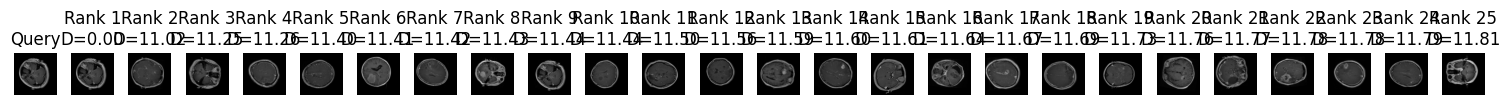

In [24]:
base_folder = "Part1"
query_img = "Part1/brain_glioma/brain_glioma_0005.jpg"
find_k_similar(base_folder, query_img, k=25)

Task 4

Comparazione tra le due tecniche:

In [25]:
def compare_label_ranking_strategies(query_img_path, k=2):
    """
    Confronta le etichette predette da due strategie:
    - distanza media per classe
    - distanza al rappresentante (prototipo) della classe
    Visualizza solo le top-k etichette con un grafico comparativo.
    """
    assert k <= 2, "k deve essere <= 2"

    query_feature = extract_hog_features_from_image(query_img_path)
    if query_feature is None:
        print("[ERRORE] Feature non estratte.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    # ===== Strategia 1: distanza media per classe =====
    distances_all = cosine_similarity(feat_matrix_part1, query_feature).flatten()
    df_all = pd.DataFrame({
        'label': lbls_part1,
        'distance': distances_all
    })
    mean_dists = df_all.groupby('label')['distance'].mean().sort_values()

    # ===== Strategia 2: distanza dal prototipo (centroide) =====
    df_features = pd.DataFrame(feat_matrix_part1)
    df_features['label'] = lbls_part1
    class_prototypes = df_features.groupby('label').mean().drop(columns=['label'], errors='ignore')
    proto_vectors = class_prototypes.values
    proto_labels = class_prototypes.index
    proto_dists = cosine_similarity(proto_vectors, query_feature).flatten()
    proto_dists_series = pd.Series(proto_dists, index=proto_labels).sort_values()

    # ===== Prendi le top-k etichette comuni =====
    top_k_mean = mean_dists.head(k)
    top_k_proto = proto_dists_series.head(k)

    union_labels = sorted(set(top_k_mean.index).union(set(top_k_proto.index)))

    # ===== Plot solo per le top-k etichette =====
    x = np.arange(len(union_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, [mean_dists[label] for label in union_labels], width, label='Distanza Media')
    ax.bar(x + width/2, [proto_dists_series[label] for label in union_labels], width, label='Distanza Prototipo')

    ax.set_ylabel('Distanza')
    ax.set_title(f"Top-{k} Strategie - Query: {os.path.basename(query_img_path)}")
    ax.set_xticks(x)
    ax.set_xticklabels(union_labels)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ===== Stampa i top-k risultati =====
    print("\n Top-k etichette per ciascuna strategia:\n")
    print("Strategia: Distanza Media")
    print(top_k_mean)

    print("\n Strategia: Prototipo di Classe")
    print(top_k_proto)

Esecuzione:

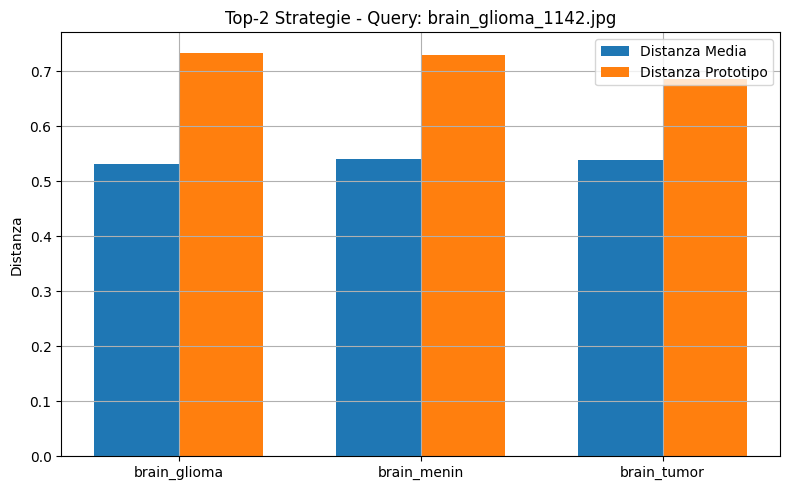


 Top-k etichette per ciascuna strategia:

Strategia: Distanza Media
label
brain_glioma    0.531155
brain_tumor     0.537933
Name: distance, dtype: float64

 Strategia: Prototipo di Classe
label
brain_tumor    0.685034
brain_menin    0.729224
dtype: float64


In [26]:
query_img = "Part2/brain_glioma/brain_glioma_1142.jpg"
compare_label_ranking_strategies(query_img, k=2)

Task 5

In [30]:

def task5_latent_semantics_hog(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da feature HOG tramite SVD, LDA o KMeans.
    Visualizza lo spazio latente ed esporta un file .txt con i pesi delle immagini.
    """
    # Caricamento feature, nomi file ed etichette
    data = np.load(feature_model_path)
    feature_matrix = data['features']
    filenames = data['filenames']
    labels = data['labels']

    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k)
        X_transformed = model.fit_transform(feature_matrix)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(labels)
        max_k = min(k, len(unique_labels) - 1)
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feature_matrix, labels)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feature_matrix)
        components = model.cluster_centers_
        X_transformed = model.transform(feature_matrix)
        method = "kmeans"

    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # Visualizzazione
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, labels, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feature_matrix, labels, k)

    # Scrittura output
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feature_matrix @ components[i].T
            else:  # KMeans: distanza inversa
                weights = -X_transformed[:, i]

            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{filenames[idx]} | Peso: {weights[idx]:.4f} | Classe: {labels[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")

Visualizzazione 

In [31]:
def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D delle immagini nello spazio latente (solo per SVD/LDA)."""
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza le immagini raggruppate da KMeans su uno spazio 2D ridotto con SVD."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.show()


Esecuzione:

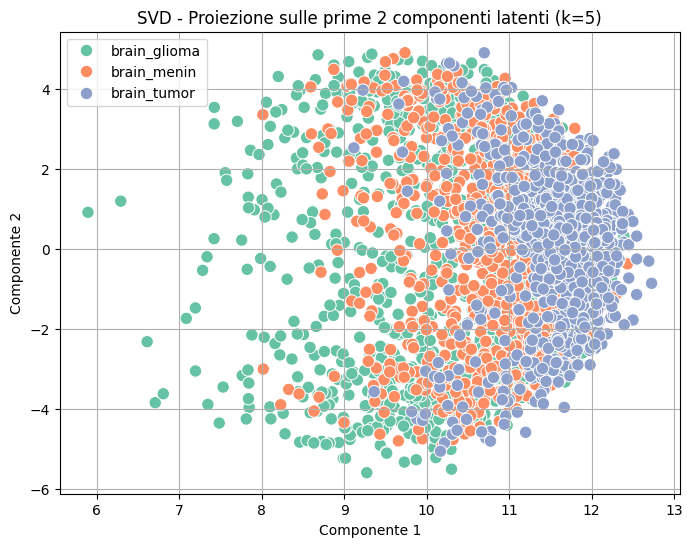

[SALVATO] Latent semantics salvati in: latent_semantics_svd_hog_features_all_k5.txt


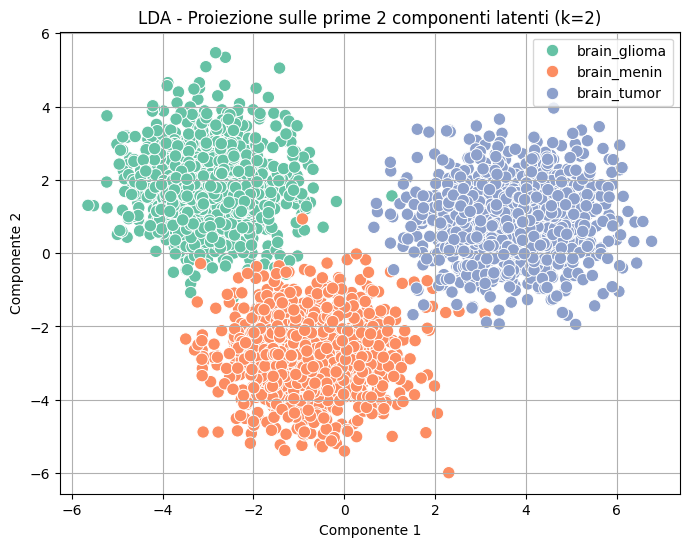

[SALVATO] Latent semantics salvati in: latent_semantics_lda_hog_features_all_k2.txt


KeyboardInterrupt: 

In [32]:
task5_latent_semantics_hog("hog_features_all.npz", "svd", 5)
task5_latent_semantics_hog("hog_features_all.npz", "lda", 2)
task5_latent_semantics_hog("hog_features_all.npz", "kmeans", 3)


Task 6

In [33]:

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    #print(f"[INFO] Spiegazione varianza per ogni componente PCA:\n{explained}")
    #print(f"[INFO] Varianza cumulativa:\n{cumulative}")
    #print(f"[INFO] Soglia impostata: {threshold}")
    #print(f"[INFO] Dimensione intrinseca stimata: {intrinsic_dim}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values


In [34]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map


\Stima automatica di k in base alla varianza spiegata:

[INFO] Feature matrix shape: (3006, 8100)
[INFO] k ottimale suggerito (soglia 90%): 956
Soglia 90% : k = 956
[INFO] k ottimale suggerito (soglia 95%): 1360
Soglia 95% : k = 1360
[INFO] k ottimale suggerito (soglia 99%): 2174
Soglia 99% : k = 2174


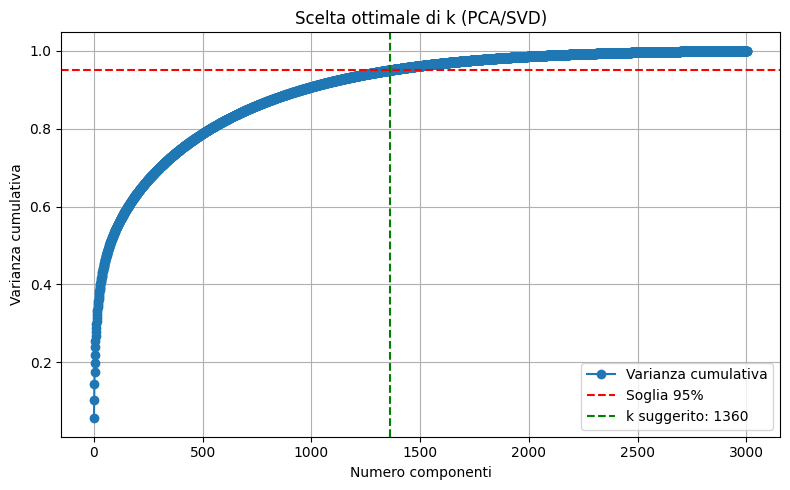

[INFO] k ottimale suggerito (soglia 95%): 1360

 Task 6b – Dimensionalità per etichetta:

[INFO] Etichette uniche trovate: 3
[INFO] k ottimale suggerito (soglia 95%): 680
 Label 'brain_glioma' : k = 680
[INFO] k ottimale suggerito (soglia 95%): 684
 Label 'brain_menin' : k = 684
[INFO] k ottimale suggerito (soglia 95%): 682
 Label 'brain_tumor' : k = 682


In [37]:
# Calcola k per varie soglie
print("\Stima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)
# Plot dettagliato per la soglia 95%
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=0.95, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=0.95)

Task7

In [78]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD

        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))


def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

In [ ]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)